In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

In [2]:
data = pd.read_pickle('After_filling_Nans')

In [3]:
df = pd.read_pickle('After preprocessing')

In [6]:
pos_reviews = data['Positive_Review'].values
pos_reviews = pos_reviews.tolist()
neg_reviews = data['Negative_Review'].values
neg_reviews = neg_reviews.tolist()
text = pos_reviews+neg_reviews

In [7]:
#converting the data into numpy arrays
summary = np.array(df.Summary)
score = df['score'].values

In [9]:
#Featurizer - Bag of words (Unigram)
# Multinomial Naive Bayes:
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
start_time = time.time()
best_params = [] #store best parameters for MultinomialNB
parameters = {'alpha':[i for i in range(1,100,10)]} 
acc = []
score = list(score)
for i in range(2000,14000,1000):
    vec = CountVectorizer(max_features = i)
    data = vec.fit_transform(summary)
    nb = MultinomialNB()
    clf = GridSearchCV(nb, parameters,cv=5)
    x_train, x_test, y_train, y_test = train_test_split(data, score, test_size=0.3, random_state=42)
    clf.fit(x_train, y_train)
    acc.append(100.0*sum(clf.predict(x_test))/len((clf.predict(x_test))))
    best_params.append(clf.best_params_)
    vec = 0
    data = 0

print("--- %s seconds ---" % (time.time() - start_time))    

--- 1041.4600849151611 seconds ---


In [12]:
##Confusion matrix
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, false negative, true positive
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN # Total num of examples

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
             bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [13]:
start_time = time.time()
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

score_Log_reg = []
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    

print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#print the log loss
a = log_loss(y_test, probs)
print("The log loss for the Naive bayes is:",a)

#print confusion matrix
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))
print('------------ %s seconds ------------'%(time.time()-start_time))

Confusion matrix:
 [[140915  13778]
 [  9455 144980]]


<Figure size 640x480 with 1 Axes>

The log loss for the Naive bayes is: 0.2660411123714337


<Figure size 800x800 with 1 Axes>

Precision : 91.32138222955693
Recall : 93.87768316767573
The accuracy is 92.48 %
------------ 1.8596832752227783 seconds ------------


In [14]:
#Logistic Regression

In [15]:
#Logistic regression hyperparameter tuning
import warnings
from sklearn.linear_model import SGDClassifier
warnings.filterwarnings('ignore')
start_time = time.time()
best_params_logreg = []
parameters = {'loss' :['log'],'penalty':['l1','l2','elasticnet'],'alpha':[float(i)/10 for i in range(1,10,1)],'n_jobs':[-1]}
warnings.filterwarnings('ignore')
clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(x_train, y_train)
best_params_logreg.append(clf.best_params_)
print('Best parameters for Logistic Regression are:',best_params_logreg)
print("--- %s seconds ---" % (time.time() - start_time))

Best parameters for Logistic Regression are: [{'alpha': 0.1, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}]
--- 302.537677526474 seconds ---


Confusion matrix:
 [[135980  18713]
 [ 21251 133184]]


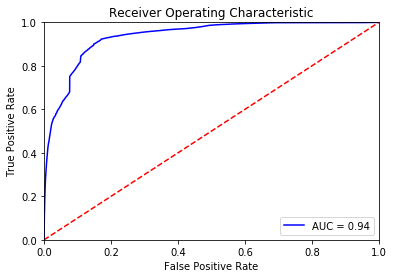

The log loss for the Logistic regression is: 0.5516793937861539


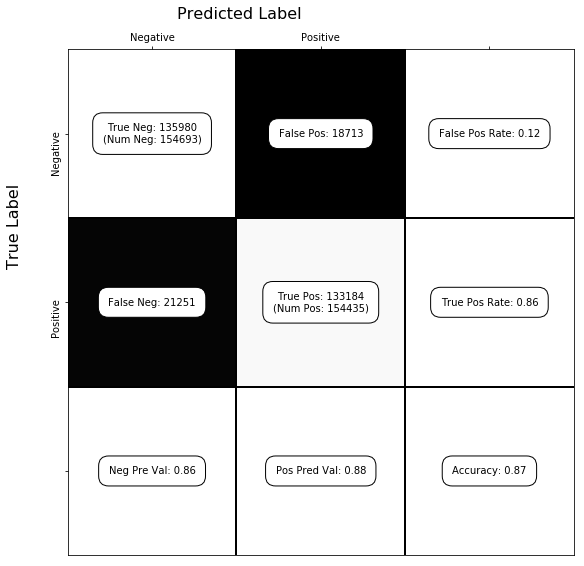

Precision : 87.68046768533941
Recall : 86.2395182439214
The accuracy is 87.07 %


In [16]:
clf = SGDClassifier(loss = 'log',penalty = 'l2',alpha = 0.1, n_jobs = -1)
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_log_ref = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n",conf_log_ref)
#ROC for a given hyperparameters for logistic regression
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#print the log loss
a = log_loss(y_test, probs)
print("The log loss for the Logistic regression is:",a)

#print confusion matrix
show_confusion_matrix(conf_log_ref,['Negative','Positive'])

#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print("Precision :",precision)
print("Recall :",recall)

tp = conf_log_ref[0][0]
tn = conf_log_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

In [ ]:
#SVM

In [17]:
#SVM hyperparameter tuning
start_time = time.time()
best_params_SVM = []
parameters = {'loss' :['hinge'],'penalty':['l1','l2','elasticnet'],'alpha':[float(i)/10 for i in range(1,10,1)],'n_jobs':[-1]}
 
clf = SGDClassifier()
clf = GridSearchCV(clf, parameters,cv=5)
clf.fit(x_train, y_train)
best_params_SVM = clf.best_params_
print("Best hyperparameters for linear SVM:",best_params_SVM)
print('------{} seconds-------'.format(time.time()-start_time))

Best hyperparameters for linear SVM: {'alpha': 0.1, 'loss': 'hinge', 'n_jobs': -1, 'penalty': 'l2'}
------280.08676314353943 seconds-------


Confusion matrix:
 [[140974  13719]
 [ 26169 128266]]


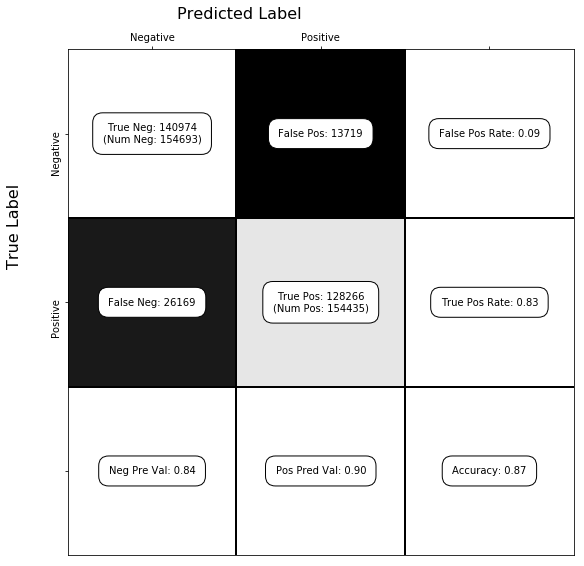

Precision : 90.33771173011233
Recall : 83.05500696085731
The accuracy is 87.1 %


In [18]:
#Linear SVM
clf = SGDClassifier(penalty = 'l2', alpha = 0.1, n_jobs =  -1, loss = 'hinge')
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_SVM_ref = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n",conf_SVM_ref)
#print confusion matrix
show_confusion_matrix(conf_SVM_ref,['Negative','Positive'])
#Precision and recall
tn = conf_SVM_ref[0,0]; fp = conf_SVM_ref[0,1]; fn = conf_SVM_ref[1,0]; tp = conf_SVM_ref[1,1];
precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)
print("Precision :",precision)
print("Recall :",recall)
tp = conf_SVM_ref[0][0]
tn = conf_SVM_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

In [20]:
# Hyperparameter tuning for MultinomialNB with Bigrams
start_time = time.time()
best_params = []
parameters = {'alpha':[i for i in range(1,100,10)]}
features = [i for i in range(10000,130000,10000)]
acc = []
score = list(score)
for i in range(2000,14000,1000):
    vec = CountVectorizer(ngram_range=(1,2),max_features = i)
    data = vec.fit_transform(summary)
    nb = MultinomialNB()
    clf = GridSearchCV(nb, parameters,cv=5)
    x_train, x_test, y_train, y_test = train_test_split(data, score, test_size=0.3, random_state=42)
    clf.fit(x_train, y_train)
    acc.append(100.0*sum(clf.predict(x_test))/len((clf.predict(x_test))))
    best_params.append(clf.best_params_)
    vec = 0
    data = 0
print('-------- %s seconds -------'%(time.time()-start_time))

-------- 1095.154911518097 seconds -------


Confusion matrix:
 [[143243  11450]
 [ 10369 144066]]


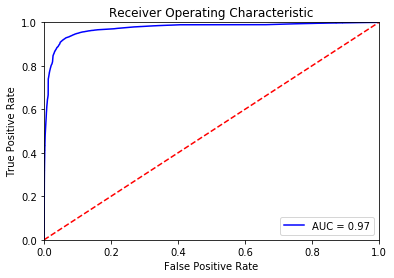

The log loss for the Naive bayes is: 0.32710414393895576


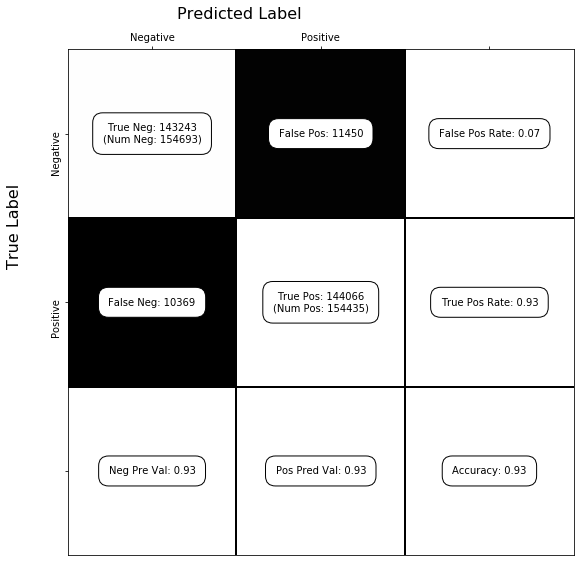

Precision : 92.63741351372207
Recall : 93.28584841519086
The accuracy is 92.94 %


In [21]:
# MultinomialNb with Bigrams
score_Log_reg = []
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    

print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#print the log loss
a = log_loss(y_test, probs)
print("The log loss for the Naive bayes is:",a)

#print confusion matrix
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

In [22]:
# Hyperparameter tuning for MultinomialNB with Bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
start_time = time.time()
best_params = []
parameters = {'alpha':[i for i in range(1,100,10)]}
acc = []
score = list(score)
for i in range(2000,14000,1000):
    vec = TfidfVectorizer(max_features = i)
    data = vec.fit_transform(summary)
    nb = MultinomialNB()
    clf = GridSearchCV(nb, parameters,cv=5)
    x_train, x_test, y_train, y_test = train_test_split(data, score, test_size=0.3, random_state=42)
    clf.fit(x_train, y_train)
    acc.append(100.0*sum(clf.predict(x_test))/len((clf.predict(x_test))))
    best_params.append(clf.best_params_)
    vec = 0
    data = 0
print('-------- %s seconds -------'%(time.time()-start_time))

-------- 724.7705626487732 seconds -------


Confusion matrix:
 [[140884  13809]
 [  9570 144865]]


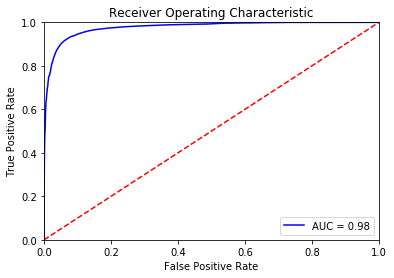

The log loss for the Naive bayes is: 0.205144275679825


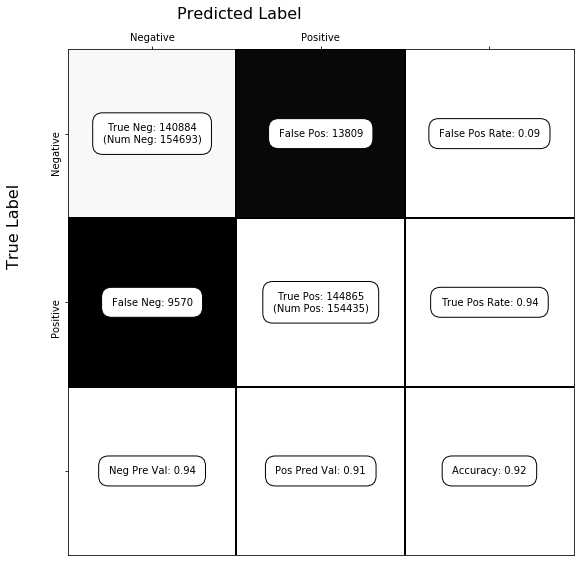

Precision : 91.29725096739226
Recall : 93.80321818240684
The accuracy is 92.44 %


In [23]:
# MultinomialNb with TF-IDF
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss

score_Log_reg = []
y_pred = clf.predict(x_test)
conf_NB = confusion_matrix(y_test, y_pred)    

print("Confusion matrix:\n",conf_NB)

#ROC for a given alpha for NB
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#print the log loss
a = log_loss(y_test, probs)
print("The log loss for the Naive bayes is:",a)

#print confusion matrix
show_confusion_matrix(conf_NB,['Negative','Positive'])

#Precision and recall
tn = conf_NB[0,0]; fp = conf_NB[0,1]; fn = conf_NB[1,0]; tp = conf_NB[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print("Precision :",precision)
print("Recall :",recall)

tp = conf_NB[0][0]
tn = conf_NB[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

In [ ]:
########word2vec


In [24]:
from gensim.models import word2vec
from gensim.models import KeyedVectors
start_time = time.time()
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print('----------- %s seconds ------------'%(time.time()-start_time))

unable to import 'smart_open.gcs', disabling that module


----------- 68.34160685539246 seconds ------------


In [25]:
model.wv.similarity('dinner','lunch')

0.6815704

In [29]:
model.wv.most_similar('tasty')

[('delicious', 0.8730390071868896),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856923937797546),
 ('flavorful', 0.7420163154602051),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012301087379456),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857703328132629)]

In [30]:
model.wv.most_similar('comfortable')

[('relaxed', 0.6222994923591614),
 ('uncomfortable', 0.6154510974884033),
 ('confortable', 0.6054231524467468),
 ('comfy', 0.5750091075897217),
 ('Comfortable', 0.5743195414543152),
 ('comfortably', 0.5482974052429199),
 ('confident', 0.5234919786453247),
 ('comforable', 0.5089609026908875),
 ('happy', 0.49969589710235596),
 ('guessed_Weitzman', 0.4883439838886261)]

In [31]:
model.wv.most_similar('london')

[('birmingham', 0.6578777432441711),
 ('nyc', 0.633285403251648),
 ('england', 0.6249368190765381),
 ('manchester', 0.6243364810943604),
 ('brooklyn', 0.6110509634017944),
 ('europe', 0.5989702939987183),
 ('essex', 0.5952245593070984),
 ('barcelona', 0.5916234254837036),
 ('alex', 0.5865465402603149),
 ('toronto', 0.5863364934921265)]

In [32]:
model.wv.most_similar('europe')

[('european', 0.7335598468780518),
 ('germany', 0.6781216859817505),
 ('spain', 0.669180154800415),
 ('england', 0.6649484038352966),
 ('america', 0.6617692708969116),
 ('usa', 0.6346731185913086),
 ('france', 0.626425564289093),
 ('greece', 0.6257439851760864),
 ('italy', 0.6248245239257812),
 ('sweden', 0.6188695430755615)]

In [33]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'] ,topn=1 )

[('queen', 0.7118192911148071)]

In [34]:
#computing the word2v for the documents
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [35]:
def has_vector_representation(w2v_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in w2v_model.wv.vocab for word in doc)

In [36]:
data =[]
i=[]
for index,doc in enumerate(text):#look up each doc in model
    if has_vector_representation(model,doc):
        data.append(document_vector(model, doc))
    else:
        i.append(index)

In [37]:
len(score),len(data)

(1030424, 1029392)

In [38]:
score = np.delete(score,i)
len(score),len(data)

(1029392, 1029392)

Confusion matrix:
 [[146589   8104]
 [ 14173 140262]]


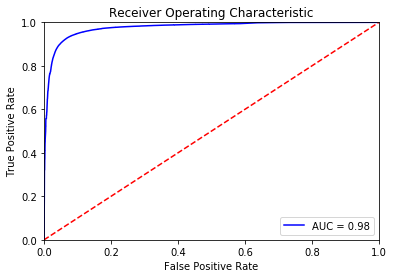

The log loss for the Logistic regression is: 0.22368447811300005


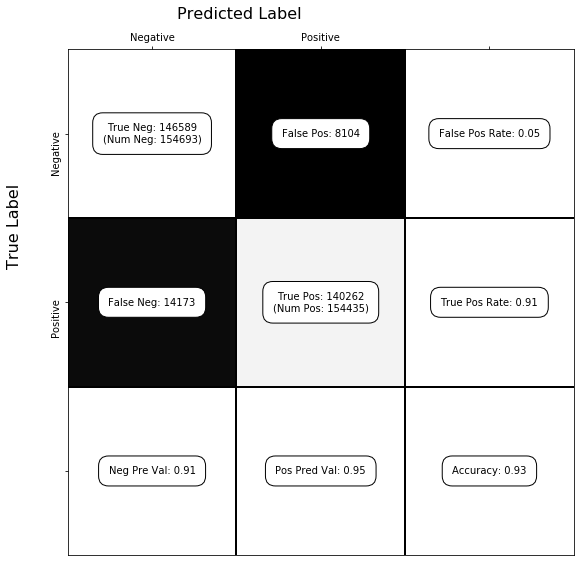

Precision : 94.53783211787066
Recall : 90.8226762068184
The accuracy is 92.79 %


In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
clf = SGDClassifier(loss = 'log',penalty = 'l2', n_jobs = -1)
#choose acc to best parameters
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
conf_log_ref = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n",conf_log_ref)
#ROC for a given hyperparameters for logistic regression
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
probs = clf.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

#Plot ROC
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#print the log loss
a = log_loss(y_test, probs)
print("The log loss for the Logistic regression is:",a)

#print confusion matrix
show_confusion_matrix(conf_log_ref,['Negative','Positive'])

#Precision and recall
tn = conf_log_ref[0,0]; fp = conf_log_ref[0,1]; fn = conf_log_ref[1,0]; tp = conf_log_ref[1,1];

precision = 100*float(tp)/(tp+fp)
recall = 100*float(tp)/(tp+fn)

print("Precision :",precision)
print("Recall :",recall)

tp = conf_log_ref[0][0]
tn = conf_log_ref[1][1]
print("The accuracy is {} %".format(round(100.0*(tp+tn)/len(y_test),2)))

In [1]:
#extraaaa
import pandas as pd

# read data
reviews_df = pd.read_csv("Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

review  is_bad_review
0   I am so angry that i made this post available...              1
1  No Negative No real complaints the hotel was g...              0
2   Rooms are nice but for elderly a bit difficul...              0
3   My room was dirty and I was afraid to walk ba...              1
4   You When I booked with your company on line y...              0

In [5]:
#sampling the data to speed up computations
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))


In [6]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

Wall time: 8.2 s


In [7]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

C:\Users\Samhitha\Anaconda3\New folder\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [8]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [9]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

unable to import 'smart_open.gcs', disabling that module


In [10]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [11]:
reviews_df.head()

review  is_bad_review  \
328097   Nothing about the hotel or staff but we would...              0   
49342    Duty manager in the night takes to me rude an...              0   
402177   Limited options in room service menu Great lo...              0   
196605                                 Good use of space               0   
328156   The room was spacious and so was the bed espe...              0   

                                             review_clean    neg    neu  \
328097  nothing hotel staff pay allege full price help...  0.000  0.605   
49342   duty manager night take rude behave unexceptab...  0.281  0.719   
402177  limited option room service menu great locatio...  0.117  0.432   
196605                                     good use space  0.000  0.508   
328156  room spacious bed especially europe even eleva...  0.000  0.789   

          pos  compound  nb_chars  nb_words  doc2vec_vector_0     ...      \
328097  0.395    0.9513       186        35         -0.061405     ...       
49342   0.000   -0.6240        89        16         -0.120158     ...       
402177  0.451    0.7506        67        11          0.037618     ...       
196605  0.492    0.4404        19         6         -0.072864     ...       
328156  0.211    0.6808       133        27         -0.071687     ...       

        word_wall  word_warm  word_water  word_welcome  word_well  word_wifi  \
328097        0.0        0.0         0.0           0.0        0.0        0.0   
49342         0.0        0.0         0.0           0.0        0.0        0.0   
402177        0.0        0.0         0.0           0.0        0.0        0.0   
196605        0.0        0.0         0.0           0.0        0.0        0.0   
328156        0.0        0.0         0.0           0.0        0.0        0.0   

        word_window  word_wonderful  word_work  word_would  
328097          0.0             0.0        0.0         0.0  
49342           0.0             0.0        0.0         0.0  
402177          0.0             0.0        0.0         0.0  
196605          0.0             0.0        0.0         0.0  
328156          0.0             0.0        0.0         0.0  

[5 rows x 185 columns]

In [12]:
#eda
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.947674
1    0.052326
Name: is_bad_review, dtype: float64

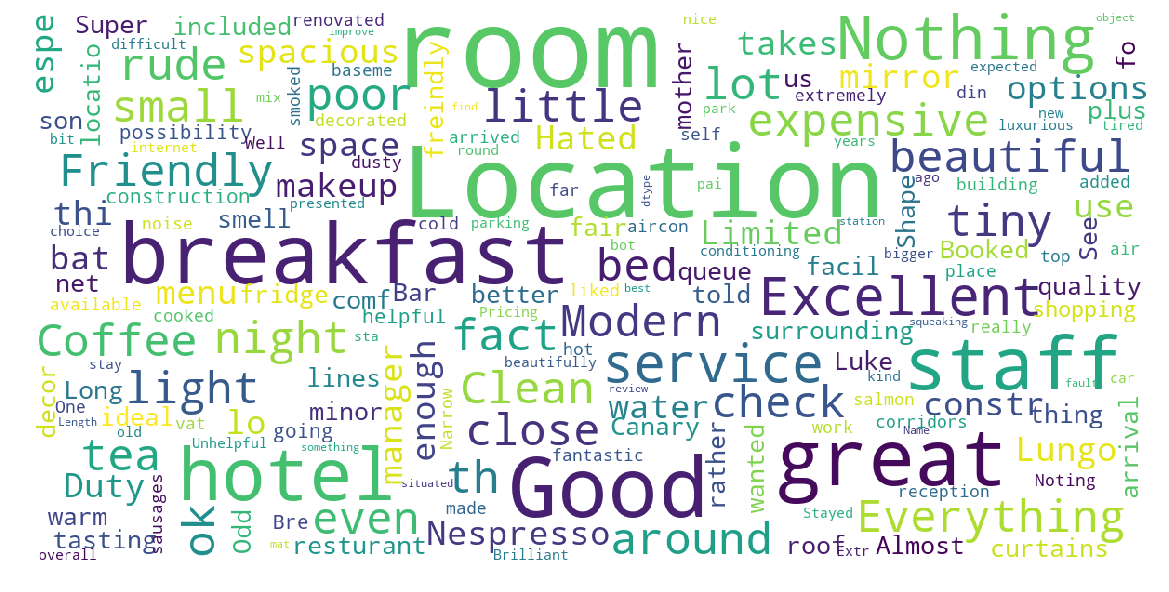

In [20]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [14]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

review    pos
207666                          Very clean friendly hotel  0.764
238998          Room clean and comfortable Good location   0.748
499846   Super helpful staff great location good break...  0.737
235414   Great location Fantastic facilities Would 100...  0.728
91505                Excellent Location Great Rooftop Bar  0.722
128667   Staff very friendly and helpful Excellent Bre...  0.719
465544   Nil Excellent breakfast Helpful staff Excelle...  0.718
241670   Friendly staff clean and nice room Comfortabl...  0.713
352152       The garden was lovely peaceful and romantic   0.708
359280   Enjoyable stay great location and good facili...  0.703

In [15]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

review    neg
29666                                      A bit noisy No  0.796
394666                Not great location Clean functional  0.649
68963                               Too noisy  Too noisy   0.630
101936                   not much not to like Great hotel  0.519
265719                      Unhelpful staff Poor internet  0.508
171548   Nothing Excellent staff service Excellent fac...  0.457
207946             Terrible building and overpricec Staff  0.437
499952         nothing Super helpful staff great location  0.436
125758                   Nothing Brilliant all round stay  0.434
37364         Nothing Very nice a good mix of old and new  0.424

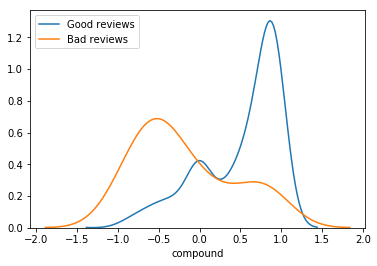

In [16]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [17]:
#modelling is bad review part
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [18]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

feature  importance
3            compound    0.061174
0                 neg    0.044811
1                 neu    0.038141
149        word_staff    0.037321
8    doc2vec_vector_2    0.034984
5            nb_words    0.032927
162         word_tiny    0.031241
9    doc2vec_vector_3    0.030804
7    doc2vec_vector_1    0.029896
6    doc2vec_vector_0    0.029532
4            nb_chars    0.028198
10   doc2vec_vector_4    0.026312
180         word_work    0.024652
2                 pos    0.023345
123       word_person    0.021762
19        word_arrive    0.021334
127         word_poor    0.018441
165          word_two    0.018206
150     word_standard    0.017914
62     word_extremely    0.016734

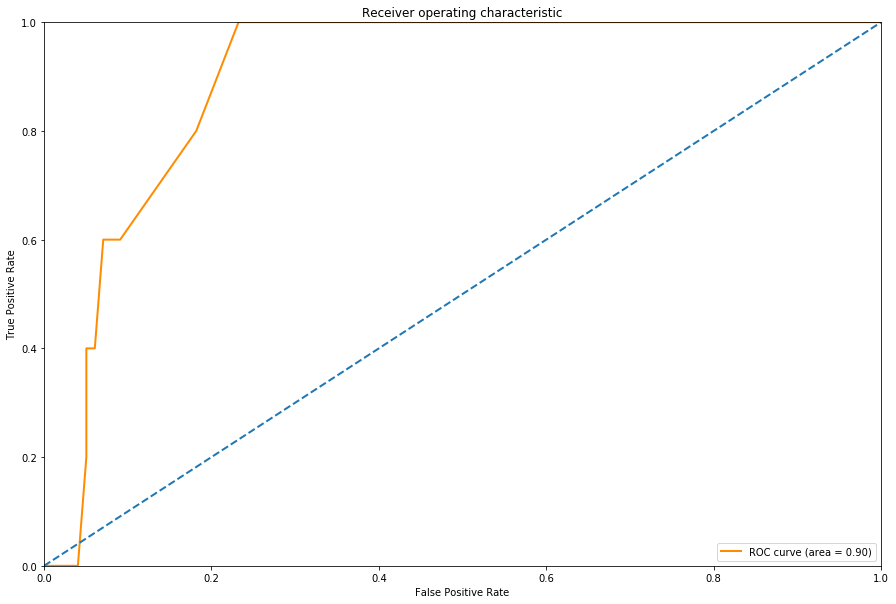

In [19]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.22')

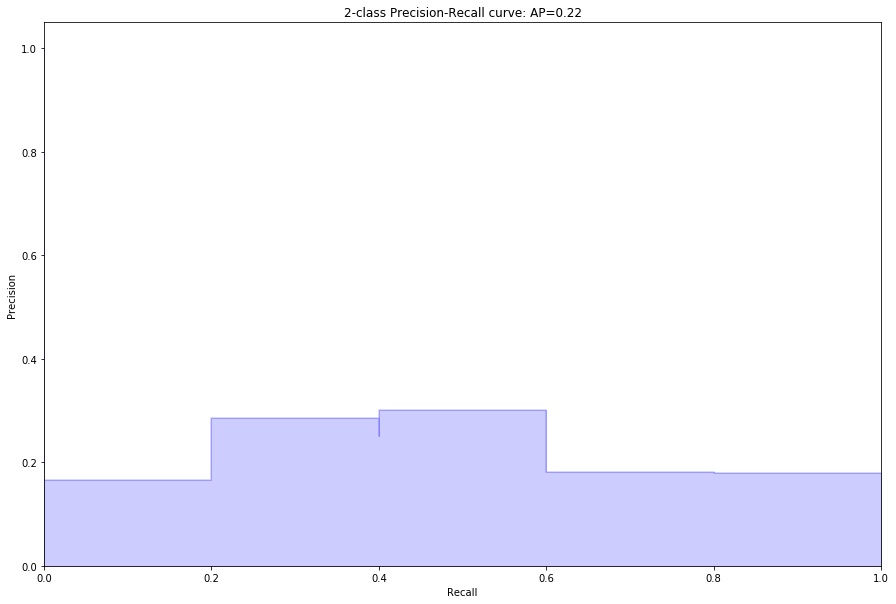

In [21]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))